<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Exeter_Job_kmers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feature extraction methods:
1. spatial autocorrelation of alist of lags per sample;
2. histogram of '1-mer' per sample = 0th markov model;

There are 3 general approaches to encoding sequence data:

1.   Ordinal encoding DNA Sequence
2.   One-hot encoding DNA Sequence
3.   DNA sequence as a “language”, known as k-mer counting


Ref:

https://www.theaidream.com/post/demystify-dna-sequencing-with-machine-learning-and-python


#Ordinal encoding DNA sequence data

In this approach, we need to encode each nitrogen base as an ordinal value. For example “ATGC” becomes [0.25, 0.5, 0.75, 1.0]. Any other base such as “N” can be a 0.


So let us create functions such as creating a NumPy array object from a sequence string, and a label encoder with the DNA sequence alphabet “a”, “c”, “g” and “t”, but also a character for anything else, “n”.

In [157]:
file_path = '/content/test.txt'

#One-hot encoding DNA Sequence

Another approach is to use one-hot encoding to represent the DNA sequence. This is widely used in deep learning methods and lends itself well to algorithms like convolutional neural networks. In this example, “ATGC” would become [0,0,0,1], [0,0,1,0], [0,1,0,0], [1,0,0,0]. And these one-hot encoded vectors can either be concatenated or turned into 2-dimensional arrays.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

def one_hot_encoder(seq_string):
  seq_string = string_to_array(seq_string)
  int_encoded = label_encoder.transform(seq_string)
  print('my int_encoded', int_encoded)

  onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
  int_encoded = int_encoded.reshape(len(int_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(int_encoded)
  onehot_encoded = np.delete(onehot_encoded, -1, 1)
  return onehot_encoded

int_encoded = label_encoder.transform(string_to_array('ACGTZnv'))
onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
print('int_encoded', int_encoded)
int_encoded = int_encoded.reshape(len(int_encoded), 1)
onehot_encoder.fit(int_encoded)
print('onehot_encoder ', onehot_encoder.categories_)
onehot_encoder.transform(int_encoded)

#outlier detection by 1-mers


In [158]:
# extract the unique chars 'chars_list' from all the samples
chars_list = set()
count_chars = 0

def func_count_unique_chars(line, counter):
  """func to get unique chars in 'line' based on current 'counter'.
  Note: set counter = set() for the first line;
  """
  for c in line:
    counter.add(c)
  return (counter)
  #sorted(set) returns a list

f = open("test.txt", "r")
for number_of_lines, line in enumerate(f):
  line = line.rstrip('\n')
  count_chars += len(line)
  chars_list = func_count_unique_chars(line, chars_list)
  if number_of_lines<5:
    print(f'Line {number_of_lines} has\t{len(line)} chars, count_chars ={count_chars},\
            the last 5 chars ={line[-5:]}, uniques={sorted(chars_list)}')

f.close()
number_of_lines = number_of_lines + 1
chars_list = sorted(chars_list)
print('*** Summary: number of lines =\t', number_of_lines)
print('number of chars =\t', count_chars)
print('unique chars =', chars_list)

Line 0 has	105 chars, count_chars =105,            the last 5 chars =GDEGE, uniques=['C', 'D', 'E', 'F', 'G']
Line 1 has	113 chars, count_chars =218,            the last 5 chars =GCEGE, uniques=['C', 'D', 'E', 'F', 'G']
Line 2 has	113 chars, count_chars =331,            the last 5 chars =GCEGC, uniques=['C', 'D', 'E', 'F', 'G']
Line 3 has	112 chars, count_chars =443,            the last 5 chars =ECGCE, uniques=['C', 'D', 'E', 'F', 'G']
Line 4 has	115 chars, count_chars =558,            the last 5 chars =CEGEE, uniques=['C', 'D', 'E', 'F', 'G']
*** Summary: number of lines =	 300
number of chars =	 32363
unique chars = ['C', 'D', 'E', 'F', 'G']


In [160]:
# 1-mers feature: generate features as the frequency of each unique chars per sample;
# equivalent to 0th order markov chain model;
import pandas as pd
import numpy as np
def func_count_chars_ordered(line, chars):
  """func to count number of strings in string 'line' based on current 'counter'.
  Note: set counter = {} for the first line;
  """
  counter = np.zeros((len(chars, )))
  #print(counter, line, chars)
  for id, c in enumerate(chars):
    #print(f'id={id}, ch={chars[id]}')
    counter[id] = line.count(chars[id])
  return counter

def func_1mers_feature(file_path, number_of_lines, chars_list):
  df = np.zeros((number_of_lines, len(chars_list)))
  #print(chars_list, df.shape)

  f = open(file_path, "r")
  for c, line in enumerate(f):
    if c<0:
      print(f'***num of chars in line {c} is {len(line), {line[-5:]}}')
    line = line.rstrip('\n')
    df[c] = func_count_chars_ordered(line, chars_list)
  f.close()

  df = pd.DataFrame(df, columns=chars_list)
  return df

In [161]:
df = func_1mers_feature(file_path, number_of_lines, chars_list)

In [162]:
df.head(3)

,C,D,E,F,G
0,17.0,10.0,32.0,15.0,31.0
1,18.0,10.0,37.0,15.0,33.0
2,17.0,10.0,38.0,15.0,33.0


#Feature based on k-mers and CountVectorizer

In [1]:
# k-mers: generate features based on k-mers and CountVectorizer per sample;
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def func_Kmers(seq, size=6):
   return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]
#convert our training data sequences into short overlapping k-mers of length 6.
#Lets do that for each species of data we have using our Kmers_funct function.

def feature_gen(file_path, kmers_size=2):
  if kmers_size==1:
    print('kmers_size must be larger than 1!')
    return;
  df = pd.read_table(file_path, header=None, names=['sequence'])
  print(f'Inside feature_gen: df has columns: {df.columns}')
  df[f'{kmers_size}-mers'] = df.apply(lambda x: func_Kmers(x[df.columns[0]], kmers_size), axis=1)
  df = df.drop(df.columns[0], axis=1)
  print(f'Inside feature_gen: df has columns: {df.columns}')

  X = list(df[df.columns[0]])
  for item in range(len(X)):
    X[item] = ' '.join(X[item])

  #Creating the Bag of Words model:
  cv = CountVectorizer(ngram_range=(1, 1))
  #TODO: ngram_range needs to be hyperparameterized
  X = cv.fit_transform(X)
  print(f'Inside feature_gen: df shape is {df.shape}, X shape is {X.shape}')
  return X

In [168]:
kmers_size = 3
file_path = "test.txt"
X = feature_gen(file_path, kmers_size)
vector_size = X.shape[1]
print(f'vector_size = {vector_size}, X shape is {X.shape}, X type is {type(X)}')

Inside feature_gen: df has columns: Index(['sequence'], dtype='object')
Inside feature_gen: df has columns: Index(['3-mers'], dtype='object')
Inside feature_gen: df shape is (300, 1), X shape is (300, 125)
vector_size = 125, X shape is (300, 125), X type is <class 'scipy.sparse._csr.csr_matrix'>


We need to now convert the lists of k-mers for each gene into string sentences of words that can be used to create the Bag of Words model. We will make a target variable y to hold the class labels.

In [7]:
X[0:3].toarray()

array([[ 2,  1,  6,  2,  6,  3,  0,  3,  0,  4,  3,  5,  8,  7,  8,  5,
         1,  4,  1,  4,  4,  3, 10,  5,  9],
       [ 1,  2,  8,  1,  6,  0,  0,  6,  0,  4,  7,  4,  9,  8,  8,  3,
         1,  3,  3,  5,  7,  3, 10,  3, 10],
       [ 0,  1,  6,  3,  6,  1,  0,  5,  0,  4,  8,  4, 11,  6,  9,  2,
         1,  5,  2,  5,  6,  4, 10,  4,  9]])

# k-mers: Step 2 — Training an ‘Auto-Encoder’ neural network

As our process is completely unsupervised and we don’t have labeled data (as outlier/non-outlier), we will use 5-layer deep ‘Auto-encoder’ neural network to train our model. It is a special type of neural network which copies input data to output data. This process is known as ‘reconstruction’. ‘Hidden layers’ of the network does the feature extraction & decoding work. At the end of the entire process definitely, some loss gets generated and the data point which is dissimilar from others incurs more loss.

Denote vector_size as the input data size;

Auto-encoder layer structure will look like:

vector_size -> 600 -> 50 -> 600 -> vector_size

Layer 1(Input Layer) has vector_size features, \
Layer 2 has 600 features, \
Layer 3 has 50 features, \
Layer 4 has 600 features, \
Layer 5(Output Layer)has vector_size features. \

Layer 1, as usual, will have all ‘Doc2Vec’ generated features from ‘Step 1’. Layer 2, 3 & 4 are hidden layers doing the actual data messaging (expansion & shrinking) and information extraction part. Actually, Layer 2 is known as ‘encoding layer’ and Layer 4 is known as ‘decoding layer’. Ultimately, the output will come out from Layer 5. ‘Autoencoders’ are trained with the same data as input & output both. So, Layer 5 output is nothing but a reconstructed version of the input with some loss. Normal data points will go through smoothly between layers, with minimal loss, but data loss for the ‘outliers’ will be more as those don’t follow the hidden data pattern.

This is the graphical representation of our 5-layer ‘Auto-encoder

In [126]:
from sklearn.neural_network import MLPRegressor
# hyperparameters
layer_features = [600, 100, 600]

auto_encoder = MLPRegressor(hidden_layer_sizes=(layer_features))
auto_encoder.fit(X.toarray(), X.toarray())
predicted_vectors = auto_encoder.predict(np.asarray(X.toarray()))

print(f'X shape is {X.shape}, X type is {type(X)}')
print(f'predicted_vectors shape is {predicted_vectors.shape}, predicted_vectors type is {type(predicted_vectors)}')
auto_encoder.score(predicted_vectors, X.toarray())

X shape is (300, 5769), X type is <class 'scipy.sparse._csr.csr_matrix'>
predicted_vectors shape is (300, 5769), predicted_vectors type is <class 'numpy.ndarray'>


0.8091166318024923

<Axes: >

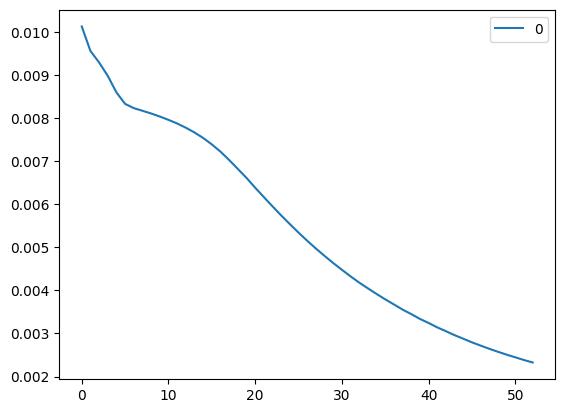

In [127]:
pd.DataFrame(auto_encoder.loss_curve_).plot()


Here X-axis denotes no of iterations.

#Step 3 — Similarity measure with output and actual work

Once we get the output vectors, we can now measure the loss. ‘Loss’ is ideally given by ‘outlier factor’ expression





In [ ]:
print(X.shape, predicted_vectors.shape)
print(X[0].toarray())
print(predicted_vectors[0])

In [ ]:
dataSetI = [3, 45, 7, 2]
dataSetII = [2, 54, 13, 15]
dataSetII = dataSetI

result = 1 - cosine(dataSetI, dataSetII)
print(result, cosine(dataSetI, dataSetII))

In [128]:
from scipy.spatial.distance import cosine
#Note: when x=y, 1-cosine(x,y) gets highest 1.0;
# Thus we want to find smallest cosine_similarities

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = vectors.shape[0]
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Saple Row Index: ', index) #df.iloc[index, 0])
        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

#We can call the above functions in order to get top ‘k’ outliers
top_numbers = 5
print(f'Top {top_numbers} outliers')
sorted_cosine_similarities = get_computed_similarities(vectors=X.toarray(), predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities, top_numbers)

Top 5 outliers
Saple Row Index:  275
Cosine Sim Val : 0.8187873307078802
---------------------------------
Saple Row Index:  122
Cosine Sim Val : 0.8208173474660064
---------------------------------
Saple Row Index:  51
Cosine Sim Val : 0.8208452627987122
---------------------------------
Saple Row Index:  170
Cosine Sim Val : 0.837710186119192
---------------------------------
Saple Row Index:  265
Cosine Sim Val : 0.8390247737687594
---------------------------------


In [129]:
sorted_cosine_similarities[:5], sorted_cosine_similarities[-5: ]

([(275, 0.8187873307078802),
  (122, 0.8208173474660064),
  (51, 0.8208452627987122),
  (170, 0.837710186119192),
  (265, 0.8390247737687594)],
 [(141, 0.9899236611923461),
  (138, 0.98995316055809),
  (164, 0.9903769892496852),
  (162, 0.9906964985157108),
  (144, 0.9913247572908251)])

In [112]:
(sorted_cosine_similarities[0][0])
#type(sorted_cosine_similarities[0][0])
#, sorted_cosine_similarities[-5: ]

140

In [ ]:
import matplotlib.pyplot as plt
for k in range(top_numbers):
  idx = sorted_cosine_similarities[k][0]
  plt.figure()
  plt.plot(list(X[idx].toarray()[0]),  'r+')
  plt.plot(predicted_vectors[idx], 'ko')

In [ ]:
#pd.plotting.lag_plot(df.loc[:, ["C"]], lag=1)
import matplotlib.pyplot as plt
for col in df.columns:
  #plt.figure()
  pd.plotting.autocorrelation_plot(df.loc[:, [col]])
plt.legend(df.columns, loc='upper right')
plt.grid()

In [ ]:
for lag in range(1,5):
  plt.figure()
  pd.plotting.lag_plot(df, lag=lag)


In [ ]:
chars_list

In [ ]:
df.describe()

In [ ]:
from numpy import mean
from numpy import std

# calculate summary statistics
data_mean, data_std = mean(df), std(df)
# identify outliers
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off
print(f'data_mean=\n{data_mean}, data_std=\n{data_std}')
print(f'lower=\n{lower}, upper=\n{upper}')

In [ ]:
outliers_idx, ch, df.loc[outliers_idx, ch]

In [ ]:
# identify outliers
for ch in chars_list:
  outliers = [x for x in df[ch] if x < lower[ch] or x > upper[ch]]
  outliers_idx = df.index[df[ch]==outliers[0]].tolist()
  #print(ch, outliers, '\n', outliers_idx, '\n')
  print(outliers_idx)


# Conclusion: outlier is
269 by 'C, G' \
161 by 'C, D' \


In [ ]:
df.boxplot(column=['C', 'D', 'F'])


In [ ]:
df.boxplot(column=['E', 'G'])

In [ ]:
df.boxplot()

from sklearn.neighbors import LocalOutlierFactor
#Note that neighbors.LocalOutlierFactor does not support predict, decision_function
#and score_samples methods by default but only a fit_predict method, as this estimator
#was originally meant to be applied for outlier detection. The scores of abnormality
#of the training samples are accessible through the negative_outlier_factor_ attribute.

n_neighbors = 150
clf = LocalOutlierFactor(n_neighbors=n_neighbors)
results = clf.fit_predict(df) #
print(np.where(results==-1))
#estimator.predict(X_test): Inliers are labeled 1, while outliers are labeled -1.
#clf.negative_outlier_factor_
#The decision_function method is also defined from the scoring function, in such
#a way that negative values are outliers and non-negative ones are inliers:
#estimator.decision_function(X_test)

#negative_outlier_factor_: The opposite LOF of the training samples. The higher, the more normal.
#Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.


In [173]:
kmers_size = 2
file_path = "test.txt"
X = feature_gen(file_path, kmers_size)
vector_size = X.shape[1]
print(f'vector_size = {vector_size}, X shape is {X.shape}, X type is {type(X)}')

Inside feature_gen: df has columns: Index(['sequence'], dtype='object')
Inside feature_gen: df has columns: Index(['2-mers'], dtype='object')
Inside feature_gen: df shape is (300, 1), X shape is (300, 25)
vector_size = 25, X shape is (300, 25), X type is <class 'scipy.sparse._csr.csr_matrix'>


In [175]:
from sklearn.neighbors import LocalOutlierFactor
n_neighbors = 2
clf = LocalOutlierFactor(n_neighbors=n_neighbors)
results = clf.fit_predict(X.toarray())
outlier_idx = np.where(results==-1)
print(f'outlier index={outlier_idx}')
print(f'outlier results={results[outlier_idx]}')
print(f'outlier negative_outlier_factor_={clf.negative_outlier_factor_[outlier_idx]}')
print(f'first 10 negative_outlier_factor_={clf.negative_outlier_factor_[:10]}')

outlier index=(array([134, 152, 161, 165, 295]),)
outlier results=[-1 -1 -1 -1 -1]
outlier negative_outlier_factor_=[-1.59845129 -1.62653131 -1.6882683  -1.6084096  -1.62794681]
first 10 negative_outlier_factor_=[-1.12573084 -1.08079427 -1.04471476 -1.04932073 -1.25113538 -1.02872418
 -1.00637272 -1.09592942 -1.13801801 -1.06051919]


In [163]:
df = func_1mers_feature(file_path, number_of_lines, chars_list)

In [167]:
from sklearn.neighbors import LocalOutlierFactor
n_neighbors = 25
clf = LocalOutlierFactor(n_neighbors=n_neighbors)
results = clf.fit_predict(df)
outlier_idx = np.where(results==-1)
print(f'outlier index={outlier_idx}')
print(f'outlier results={results[outlier_idx]}')
print(f'outlier negative_outlier_factor_={clf.negative_outlier_factor_[outlier_idx]}')
print(f'first 10 negative_outlier_factor_={clf.negative_outlier_factor_[:10]}')

outlier index=(array([ 45, 137, 140, 143, 146, 148, 155, 164, 190, 262, 288]),)
outlier results=[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
outlier negative_outlier_factor_=[-1.6248564  -1.81192977 -1.87802966 -1.54783341 -1.68208315 -1.56941368
 -1.74870834 -1.63221913 -1.52045987 -1.91856182 -1.70071625]
first 10 negative_outlier_factor_=[-1.07490544 -0.94729289 -1.01444357 -1.01625166 -1.07140791 -0.98924822
 -1.04564772 -1.15528783 -0.9813854  -1.0602941 ]


In [ ]:
df.boxplot()


outliers as indicated by out of range of mean by 2*std:\
Conclusion: outlier with shared columns is:\
161 by 'C, D' \
269 by 'C, G' \

C [50, 77, 161, 170, 265, 269]\
D [24, 63, 100, 104, 122, 133, 151, 154, 159, 161, 164, 169, 187, 202, 228, 252]\
E [11, 25, 135, 141, 166, 283, 287]\
F [13, 54, 56, 147, 152, 154, 155, 163, 176]\
G [94, 269]\



In [ ]:
from sklearn.neighbors import LocalOutlierFactor
n_neighbors = 2
clf = LocalOutlierFactor(n_neighbors=n_neighbors)
#results = clf.fit_predict(df[['G']])
results = clf.fit_predict(df)

outlier_idx = np.where(results==-1)
print(f'outlier index={outlier_idx}')
print(f'outlier results={results[outlier_idx]}')
print(f'outlier negative_outlier_factor_={clf.negative_outlier_factor_[outlier_idx]}')
print(f'first 10 negative_outlier_factor_={clf.negative_outlier_factor_[:10]}')

https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py

Outlier detection with Local Outlier Factor (LOF)


In [ ]:
import numpy as np

np.random.seed(42)

X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [ ]:
X_inliers.shape, np.random.randn(100, 2).shape, X_outliers.shape, n_outliers, X.shape

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

#Simple Anomaly Detection using Unsupervised KNN

Ref: https://www.kaggle.com/code/kimchanyoung/simple-anomaly-detection-using-unsupervised-knn

KNN is a supervised learning-based algorithm.
However, using KNN's distance calculation method can also be used as an unsupervised learning method.

In this work, we will use Scikit-Learn's NearestNeighbors, which we can use it for unsupervised learning

sklearn.neighbors.NearestNeighbors
class sklearn.neighbors.NearestNeighbors(*, n_neighbors=5, radius=1.0, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None)
n_neighbors : int, default=5 (Number of neighbors to use by default for kneighbors queries.)
radius : float, default=1.0 (Range of parameter space to use by default for radius_neighbors queries.)
algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’ (Algorithm used to compute the nearest neighbors)
metric : str or callable, default=’minkowski’ (the distance metric to use for the tree.)
p : int, default=2 (Parameter for the Minkowski metric from sklearn.metrics.pairwise.pairwise_distances. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.)





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [ ]:
df.columns

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
plt.scatter(df["C"], df["D"], color='Red')
ax.set_xlabel('C', fontsize='11')
ax.set_ylabel('D', fontsize='11')
plt.title('C vs D frequency')
plt.grid()
plt.show()

In [ ]:
# create model
n_neighbors = 10
nbrs = NearestNeighbors(n_neighbors = n_neighbors)
# fit model
nbrs.fit(df)


In [ ]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(df)
# plot
plt.figure(figsize=(15, 7))
plt.plot(distances.mean(axis =1))

In [ ]:
distances = pd.DataFrame(distances)
distances_mean = distances.mean(axis =1)
distances_mean

In [ ]:
distances

In [ ]:
#Set thresholds with reference to statistics.

distances_mean.describe()


In [ ]:
np.linspace(0, 3, num=4)

In [ ]:
#Since 75th percentile is 8.35, we will set threshold into 9.0
#Since 75th percentile is 1.32, we will set threshold into 1.5
for th in np.linspace(1.9, 3, num=5):
  outlier_index = np.where(distances_mean > th)
  print(th, len(list(outlier_index[0])), outlier_index)


In [ ]:
outlier_values = df.iloc[outlier_index]
outlier_values

In [ ]:
outlier_values

In [ ]:
fig, axs = plt.subplots(1, len(chars_list), figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(0, len(chars_list)):
    axs[i].plot(df[chars_list[i]], color = "b", marker="+")
    axs[i].plot(outlier_values[chars_list[i]], color='r', marker="o") #s=80, facecolors='none', edgecolors='r'
    axs[i].set_title(chars_list[i])

In [ ]:
fig, axs = plt.subplots(1, len(chars_list)-1, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(1, len(chars_list)):
    axs[i-1].scatter(df["C"], df[chars_list[i]], color = "b", marker="+")
    axs[i-1].scatter(outlier_values["C"], outlier_values[chars_list[i]], marker="o", s=80, facecolors='none', edgecolors='r')
    axs[i-1].set_title(chars_list[i])

# Conclusion of outlier with single feature separately:
269 by 'C, G' \
161 by 'C, D' \

#Isolation Forest
One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The ensemble.IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.


#max_features int or float, default=1.0
The number of features to draw from X to train each base estimator.

If int, then draw max_features features.

If float, then draw max(1, int(max_features * n_features_in_)) features.

Note: using a float number less than 1.0 or integer less than number of features will enable feature subsampling and leads to a longer runtime.


In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=0) #len(chars_list))
clf.fit(df)

In [ ]:
clf.n_features_in_, clf.feature_names_in_

In [ ]:
#Predict if a particular sample is an outlier or not.
results = clf.predict(df)
outlier_idx = np.where(results==-1)
print(f'num of outliers = {len(outlier_idx[0])}, outlier_idx={outlier_idx}')

In [ ]:
results.shape, len(outlier_idx[0])

In [ ]:
#Opposite of the anomaly score defined in the original paper.
results = clf.score_samples(df)
plt.plot(range(300), results)
plt.plot(outlier_idx[0], results[outlier_idx[0]], 'r+')

In [ ]:
plt.plot(results[outlier_idx])


In [ ]:
clf = IsolationForest(max_samples=100, random_state=0, max_features=2) #len(chars_list))
clf.fit(df[['C', 'D']])

import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    df[['C', 'D']],
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(df['C'], df['D'], s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.show()